Урок 7. Классификация с помощью KNN. Кластеризация K-means

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [128]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

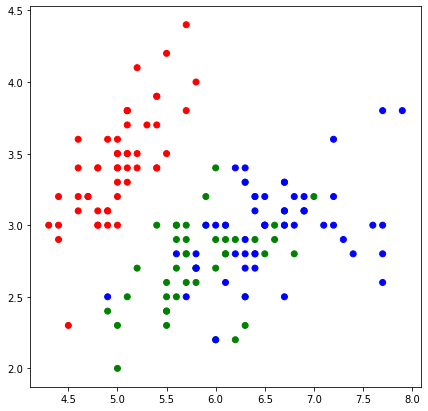

In [50]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [15]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [16]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes= {class_item: 0 for class_item in set(y_train)}

        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [17]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [280]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=47)

In [281]:
k = 5
y_pred = knn(X_train, y_train, X_test, k)

In [282]:
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.840


In [57]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

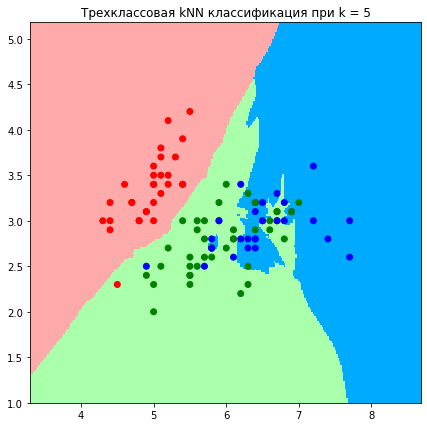

In [146]:
get_graph(X_train, y_train, k)

# Реализуем взвешенное голосование для алгоритма из лекции

In [283]:
# Голоса будут развесовываться в зависимости от дальности соседей
def w_dist_knn(x_train, y_train, x_test, k):
    
    # Для подсчета весов реализуем меру близости cosine similarity
    def cos_sim(a, b):
        return np.sum(np.multiply(a,b))/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Кроме того - рассчитаем вес данной пары
            weight = cos_sim(x, x_train[i])
            
            # Записываем в список значение расстояния, веса и ответа на объекте обучающей выборки
            test_distances.append((distance, weight, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes= {class_item: 0 for class_item in set(y_train)}

        # Сортируем список, и выбираем первые k элементов по дальности
        # Только в данном случае считаться будет не частота появления класса,
        # А сумма весов по каждому классу
        
        for d in sorted(test_distances)[:k]:
            classes[d[2]] += d[1]
   
        # Записываем в список ответов класс с наибольшим итоговым весом
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [284]:
k = 5
y_pred = w_dist_knn(X_train, y_train, X_test, k)

In [285]:
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.860


In [150]:
# Ха.. точность чуточку подросла ) была 0.840

In [286]:
# Кстати, странная история. Вот сейчас у меня Евклидова метрика используется для выборки N ближайших, 
# а косинусное сходство - в качестве веса данного ответа
# По логике - дистанция в этом алгоритме вообще лишняя, поскольку косинусное сходство и так, 
# по сути функциональная замена евклидовой метрике
# Но если выборку N ближайших сделать на основе косинусного сходства - то точность модели очень заметно падает

from scipy import spatial

def w_cos_knn(x_train, y_train, x_test, k):
    
    # Для подсчета весов реализуем меру близости cosine similarity
    # def cos_sim(a, b):
    #    return np.sum(np.multiply(a,b))/(np.sqrt(np.sum(a**2)) * np.sqrt(np.sum(b**2)))
    
    # Для чистоты эксперимента будем использовать готовую функцию cosine similarity из scipy
    
    answers = []
    for x in x_test:
        test_weights = []
            
        for i in range(len(x_train)):
            
            # Рассчитаем вес данной пары
            # weight = cos_sim(x, x_train[i])
            weight = 1 - spatial.distance.cosine(x, x_train[i])
            
            # Записываем в список значение веса и ответа на объекте обучающей выборки
            test_weights.append((weight, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes= {class_item: 0 for class_item in set(y_train)}

        # Сортируем список, и выбираем k элементов c максимальным весом
        # В данном случае считаться будет не частота появления класса,
        # А сумма весов по каждому классу
        
        for d in sorted(test_weights)[-k:]:
            classes[d[1]] += d[0]
   
        # Записываем в список ответов класс с наибольшим итоговым весом
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [287]:
k = 5
y_pred = w_cos_knn(X_train, y_train, X_test, k)

In [288]:
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.620


In [289]:
# То-есть либо я где-то все-таки ошибся - либо по каким-то неведомым причинам косинусное сходство - 
# негодная мера на данном датасете в качестве основного критерия поиска ближайших. А вот как дополнительный
# критерий веса - прибавляет к евклидовой метрике точности (я прогонял на разных подвыборках - 
# стабильная прибавка к качеству при использовании и дистанции и косинусной меры вместе)